In [1]:
import sys
sys.path.insert(0, '../../Utilities/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import math

D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1ty

In [2]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
np.random.seed(1234)
tf.set_random_seed(1234)

In [3]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, uend,tb, X_f, layers, lb, ub,u_lb,u_ub):
        
        #    lb = np.array([0, 0])      ub = np.array([1, 1])
        
        X0 = np.concatenate((x0, 0*x0-1), 1)              #    初始  
        X1 = np.concatenate((x0, 0*x0+1), 1) 
        X_lb = np.concatenate((0*tb + lb[0], tb), 1)    #    边界0
        X_ub = np.concatenate((0*tb + ub[0], tb), 1)    #    边界1    
        
        self.lb = lb
        self.ub = ub
               
        self.x0 = X0[:,0:1]
        self.t0 = X0[:,1:2]
   
        self.t1 = X1[:,1:2]
        
        self.x_lb = X_lb[:,0:1]
        self.t_lb = X_lb[:,1:2]

        self.x_ub = X_ub[:,0:1]
        self.t_ub = X_ub[:,1:2]
        
        self.x_f1 = X_f[:,0:1]
        self.t_f1 = X_f[:,1:2]
        
        
        self.u_lb=u_lb
        self.u_ub=u_ub
        #分别是初始时刻的实部和虚部
        self.u0 = u0
        self.uend = uend
        self.losslossloss=[]
        # Initialize NNs
        self.layers = layers
        
        self.loss1weight=1
        self.loss2weight=1
        
        
        sigma=10
        # Initialize spatial and temporal Fourier features
        self.W_x =tf.Variable(tf.random_normal([1, layers[0] //2], dtype=tf.float32)  * 1, dtype=tf.float32, trainable=False)
        self.W_t = tf.Variable(tf.random_normal([1, layers[0] //2], dtype=tf.float32)  * sigma, dtype=tf.float32, trainable=False)
        
        
            # Initialize encoder weights and biases
        self.encoder_weights_x_1 = self.xavier_init([ layers[1], layers[1]])
        self.encoder_biases_x_1 = self.xavier_init([1, layers[1]])

        self.encoder_weights_x_2 = self.xavier_init([ layers[1], layers[1]])
        self.encoder_biases_x_2 = self.xavier_init([1, layers[1]])
            
        self.encoder_weights_t_1 = self.xavier_init([ layers[1], layers[1]])
        self.encoder_biases_t_1 = self.xavier_init([1, layers[1]])

        self.encoder_weights_t_2 = self.xavier_init([ layers[1], layers[1]])
        self.encoder_biases_t_2 = self.xavier_init([1, layers[1]])           
        
        
        
        
        
        
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf Placeholders
        #形参 占位符，行数不确定，列数确定为1
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        self.t1_tf = tf.placeholder(tf.float32, shape=[None, self.t1.shape[1]])        
        self.u_lb_tf = tf.placeholder(tf.float32, shape=[None, self.u_lb.shape[1]])
        self.u_ub_tf = tf.placeholder(tf.float32, shape=[None, self.u_ub.shape[1]])
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.uend_tf = tf.placeholder(tf.float32, shape=[None, self.uend.shape[1]])                
        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb.shape[1]])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb.shape[1]])
        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub.shape[1]])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub.shape[1]])
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f1.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f1.shape[1]])
        self.x_f1_tf = tf.placeholder(tf.float32, shape=[None, self.x_f1.shape[1]])
        self.t_f1_tf = tf.placeholder(tf.float32, shape=[None, self.t_f1.shape[1]])
        
        
        
        # tf Graphs  进行预测
        self.u0_pred= self.net_uv(self.x0_tf, self.t0_tf)
        self.uend_pred= self.net_uv(self.x0_tf, self.t1_tf)
        self.u_lb_pred= self.net_uv(self.x_lb_tf, self.t_lb_tf)
        self.u_ub_pred = self.net_uv(self.x_ub_tf, self.t_ub_tf)
        self.f_u_pred= self.net_f_uv(self.x_f_tf, self.t_f_tf)
        self.hsadasjd=1
        
        self.f_u1_pred= self.net_f_uv(self.x_f1_tf, self.t_f1_tf)    
        
        
        
        self.lossf_upred=tf.pow(tf.reduce_mean(tf.square(self.f_u1_pred)),1/1)          
        
        self.loss111 = tf.pow((tf.reduce_mean(tf.square(self.u0_tf- self.u0_pred )) + \
                    tf.reduce_mean(tf.square(self.uend_tf  - self.uend_pred )) + \
                    tf.reduce_mean(tf.square(self.u_ub_tf   - self.u_ub_pred )) + \
                    tf.reduce_mean(tf.square(self.u_lb_tf  - self.u_lb_pred))),1)       
        
        self.loss222 =tf.pow(tf.reduce_mean(tf.square(self.f_u_pred)),1)      


        self.loss = tf.pow(tf.reduce_mean(tf.square(self.u0_tf- self.u0_pred )) + \
                    tf.reduce_mean(tf.square(self.uend_tf  - self.uend_pred )) + \
                    tf.reduce_mean(tf.square(self.u_ub_tf   - self.u_ub_pred )) + \
                    tf.reduce_mean(tf.square(self.u_lb_tf  - self.u_lb_pred)),1/3) +\
                    tf.pow(tf.reduce_mean(tf.square(self.f_u_pred)),1/3)                 
            
        self.losslosss = tf.pow(tf.reduce_mean(tf.square(self.u0_tf- self.u0_pred )) + \
                    tf.reduce_mean(tf.square(self.uend_tf  - self.uend_pred )) + \
                    tf.reduce_mean(tf.square(self.u_ub_tf   - self.u_ub_pred )) + \
                    tf.reduce_mean(tf.square(self.u_lb_tf  - self.u_lb_pred)),1/2) +\
                    tf.pow(tf.reduce_mean(tf.square(self.f_u_pred)),1/2)       
        
        
        self.losslosssloss = tf.pow(tf.reduce_mean(tf.square(self.u0_tf- self.u0_pred )) + \
                    tf.reduce_mean(tf.square(self.uend_tf  - self.uend_pred )) + \
                    tf.reduce_mean(tf.square(self.u_ub_tf   - self.u_ub_pred )) + \
                    tf.reduce_mean(tf.square(self.u_lb_tf  - self.u_lb_pred)),1) +\
                    tf.pow(tf.reduce_mean(tf.square(self.f_u_pred)),1) 
            
        
        # Optimizers  maxiter最大迭代次数  maxfun最大求值次数 maxcor int变量的最大数量
        #maxls 可选的最大搜索步数
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 100000,
                                                                           'maxfun': 100000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        
        self.optimizer11 = tf.contrib.opt.ScipyOptimizerInterface(self.losslosss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 100000,
                                                                           'maxfun': 100000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        
        self.optimizer22 = tf.contrib.opt.ScipyOptimizerInterface(self.losslosssloss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 100000,
                                                                           'maxfun': 100000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})            
        '''
        是一个寻找全局最优点的优化算法，引入了二次方梯度校正
        除了利用反向传播算法对权重和偏置项进行修正外，也在运行中不断修正学习率。
        根据其损失量学习自适应，损失量大则学习率大，进行修正的角度越大，损失量小，修正的幅度也小，学习率就小，
        但是不会超过自己所设定的学习率。20
        3
        '''
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                
        # tf session  配置Session运行参数&&GPU设备指定）
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        #初始化模型的参数
        init = tf.global_variables_initializer()
        self.sess.run(init)
    
    
    
    
    
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
        return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                           dtype=tf.float32)

    # Initialize the network
    def initialize_NN(self, layers):
        weights = []
        biases = []
        
        num_layers = len(layers)
        for l in range(0, num_layers - 2):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.random_normal([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        
#        W = self.xavier_init(size=[2 *layers[-2], layers[-1]])
        W = self.xavier_init(size=[layers[-2], layers[-1]])
        b = tf.Variable(tf.random_normal([1, layers[-1]], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)
        biases.append(b)
        
        return weights, biases
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        #将初始输入X映射到-1到1之间为H
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        
        x = H[:,0:1]
        t = H[:,1:2]

        # Temporal Fourier feature encoding
        H_t = tf.concat([tf.sin(tf.matmul(t, self.W_t)),
                         tf.cos(tf.matmul(t, self.W_t))], 1)   # H1  (N ,50))
        # Spatial Fourier feature encoding
        H_x = tf.concat([tf.sin(tf.matmul(x, self.W_x)),
                         tf.cos(tf.matmul(x, self.W_x))], 1) 
        
        
        encoder_11 = tf.tanh(tf.add(tf.matmul(H_t, self.encoder_weights_t_1), self.encoder_biases_t_1))
        encoder_21 = tf.tanh(tf.add(tf.matmul(H_t, self.encoder_weights_t_2), self.encoder_biases_t_2))  
        encoder_12 = tf.tanh(tf.add(tf.matmul(H_x, self.encoder_weights_x_1), self.encoder_biases_x_1))
        encoder_22 = tf.tanh(tf.add(tf.matmul(H_x, self.encoder_weights_x_2), self.encoder_biases_x_2))              

        # Pass through a MLP
        for l in range(0, num_layers-2):
            W = self.weights[l]
            b = self.biases[l]
            H_t = tf.math.multiply(tf.tanh(tf.add(tf.matmul(H_t, W), b)), encoder_11) + \
                    tf.math.multiply(1 - tf.tanh(tf.add(tf.matmul(H_t, W), b)), encoder_21)
    
            H_x = tf.math.multiply(tf.tanh(tf.add(tf.matmul(H_x, W), b)), encoder_12) + \
                    tf.math.multiply(1 - tf.tanh(tf.add(tf.matmul(H_x, W), b)), encoder_22)    

        # Merge the outputs via point-wise multiplication
        H = tf.multiply(H_x, H_t)   

        W = self.weights[-1]
        b = self.biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        
        
        
        return H
    
    def net_uv(self, x, t):
        X = tf.concat([x,t],1)
        
        uv = self.neural_net(X, self.weights, self.biases)


        return uv
    
    
    
    def net_f_uv(self, x, t):
        
        u = self.net_uv(x,t)       
        u_t = tf.gradients(u, t)[0]
        u_tt = tf.gradients(u_t, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_xt = tf.gradients(u_x, t)[0]
        y=t 
        a1=1
        a2=8
        k=1
        f_u1 = u_xx+u_tt+k*k*u-(-(a1*math.pi*a1*math.pi)*tf.sin(a1*math.pi*x)*tf.sin(a2*math.pi*t)-(a2*math.pi*a2*math.pi)*tf.sin(a1*math.pi*x)*tf.sin(a2*math.pi*t)+k*k*tf.sin(a1*math.pi*x)*tf.sin(a2*math.pi*t))
        f_u= f_u1
        return f_u
    
    def callback(self,loss,f_u_pred,u0_pred,uend_pred,u_ub_pred,u_lb_pred):
        self.losslossloss.append(loss)
        
        sss=self.hsadasjd
        if sss%200==10:        
            losssss =tf.reduce_mean(tf.square(f_u_pred))
            array1 = losssss.eval(session=tf.Session())      
            zkjxJXhzs = tf.reduce_mean(tf.square(u0_pred))+tf.reduce_mean(tf.square(uend_pred))+tf.reduce_mean(tf.square(u_ub_pred))+tf.reduce_mean(tf.square(u_lb_pred))
            array4 = zkjxJXhzs.eval(session=tf.Session())    
            print('It: %d, Loss1: %.9e,loss2: %.9e' % 
                      (sss,array4,array1))
            
        sss=sss+1
        self.hsadasjd=sss             
            
            
            
    
    
    def train(self, nIter):   
        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,self.uend_tf:self.uend,self.t1_tf:self.t1,
                   self.u0_tf: self.u0,self.u_lb_tf:self.u_lb,self.u_ub_tf:self.u_ub,
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f1_tf: self.x_f1, self.t_f1_tf: self.t_f1}    
            
        lossloss = []
        lossloss1=[]
        lossloss2=[]
        

        self.x_f = self.x_f1
        self.t_f = self.t_f1         
        
        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,self.uend_tf:self.uend,self.t1_tf:self.t1,
                   self.u0_tf: self.u0,self.u_lb_tf:self.u_lb,self.u_ub_tf:self.u_ub,
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f1_tf: self.x_f1, self.t_f1_tf: self.t_f1,self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}        
        

        start_time = time.time()
        loss_value11 = self.sess.run(self.loss, tf_dict)
        lossloss.append(loss_value11)
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            if it % 200 == 0:
                
                loss_value111 = self.sess.run(self.loss111, tf_dict)
                lossloss1.append(loss_value111)
                
                loss_value222 = self.sess.run(self.lossf_upred, tf_dict)
                lossloss2.append(loss_value222)
                   
                elapsed = time.time() - start_time
                print('It: %d, Loss1: %.4e,loss2: %.4e Time: %.2f' % 
                      (it, loss_value111,loss_value222,elapsed))
                start_time = time.time()
                loss_value11 = self.sess.run(self.loss, tf_dict)
                lossloss.append(loss_value11)  
            
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict, 
                                fetches = [self.loss,self.f_u_pred,self.u0_pred,self.uend_pred,self.u_ub_pred,self.u_lb_pred], 
                                loss_callback = self.callback)

        self.optimizer11.minimize(self.sess, 
                                feed_dict = tf_dict, 
                                fetches = [self.losslosss,self.f_u_pred,self.u0_pred,self.uend_pred,self.u_ub_pred,self.u_lb_pred], 
                                loss_callback = self.callback
                               )     

        self.optimizer22.minimize(self.sess, 
                                feed_dict = tf_dict, 
                                fetches = [self.losslosssloss,self.f_u_pred,self.u0_pred,self.uend_pred,self.u_ub_pred,self.u_lb_pred], 
                                loss_callback = self.callback
                               )     

        return lossloss
    
    def predict(self, X_star):
        
        tf_dict = {self.x0_tf: X_star[:,0:1], self.t0_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u0_pred, tf_dict)  
        
        
        tf_dict = {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]}
        
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
               
        return u_star,f_u_star
    
    def predict2(self, X_star):
        
        tf_dict = {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]}
        
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
               
        return f_u_star    
    def loss_show(self):
        return self.losslossloss

In [4]:
def heatsolution(x,t):
    a1=1
    a2=8
    return np.sin(a1*np.pi*x)*np.sin(a2*np.pi*t)

In [5]:
if __name__ == "__main__": 
         
    
    # Doman bounds
    lb = np.array([-1, -1])
    ub = np.array([1, 1])

    N0 = 1200                                      #初始点
    N_b = 1200                                     #边界点
    N_f = 10000                             #适配点
    layers = [50,50,50,50,1]  
    #读取真实解
    x=np.linspace(-1,1,1200).flatten()[:,None]   
    t=np.linspace(-1,1,1200).flatten()[:,None]   
    res=np.zeros([len(x),len(t)])  
    for i in range(len(x)):
        for j in range(len(t)):
            res[i,j]=heatsolution(x[i],t[j])
       
    X, T = np.meshgrid(x, t)
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    #选定初始点N0=100个点
    idx_x = np.random.choice(x.shape[0], N0, replace=False)   
    x0 = x[idx_x,:]
    u0 = res[idx_x,0:1]
    uend=res[idx_x,-1]
    #选择N_b=50个边界点
    idx_t = np.random.choice(t.shape[0], N_b, replace=False)
    tb = t[idx_t,:]
    u_lb = res[0,idx_t]
    u_ub=res[-1,idx_t]
    
    #N_f=2000个随机搭配点   第一列位置 第二列时间
    
    
    X_f = lb + (ub-lb)*lhs(2, N_f)
    
    x0=np.array(x0).flatten()[:,None]
    u0=np.array(u0).flatten()[:,None]
    uend=np.array(uend).flatten()[:,None]
    u_lb=np.array(u_lb).flatten()[:,None]
    u_ub=np.array(u_ub).flatten()[:,None]

In [6]:
    model = PhysicsInformedNN(x0, u0,uend,tb, X_f, layers, lb, ub,u_lb,u_ub)       

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [7]:
    LOSS=model.train(2000)

It: 0, Loss1: 2.9521e+00,loss2: 1.0066e+05 Time: 68.42
It: 200, Loss1: 1.3163e-03,loss2: 1.2633e+01 Time: 190.49
It: 400, Loss1: 3.3825e-04,loss2: 3.0455e+01 Time: 188.60
It: 600, Loss1: 5.1703e-04,loss2: 1.3046e+01 Time: 190.82
It: 800, Loss1: 2.1170e-04,loss2: 1.9269e+01 Time: 246.14
It: 1000, Loss1: 1.8822e-04,loss2: 4.9236e+00 Time: 372.77
It: 1200, Loss1: 1.3971e-04,loss2: 1.2138e+01 Time: 380.41
It: 1400, Loss1: 5.3873e-04,loss2: 1.9938e+01 Time: 378.84
It: 1600, Loss1: 2.2560e-04,loss2: 7.5118e+00 Time: 379.26
It: 1800, Loss1: 1.9590e-04,loss2: 8.8665e+00 Time: 305.42
It: 10, Loss1: 1.297045092e-04,loss2: 7.782369256e-01
It: 210, Loss1: 7.517433551e-05,loss2: 1.671382636e-01
It: 410, Loss1: 3.121915142e-05,loss2: 7.063189894e-02
It: 610, Loss1: 1.783770313e-05,loss2: 3.969983384e-02
It: 810, Loss1: 9.275067896e-06,loss2: 2.536219545e-02
It: 1010, Loss1: 5.079736184e-06,loss2: 1.641313173e-02
It: 1210, Loss1: 4.004557923e-06,loss2: 1.187666319e-02
It: 1410, Loss1: 2.869528771e-06

In [8]:
    lb = np.array([-1, -1])
    ub = np.array([1, 1])
    #读取真实解
    x=np.linspace(-1,1,1200).flatten()[:,None]   
    t=np.linspace(-1,1,1200).flatten()[:,None]   
    res=np.zeros([len(x),len(t)])  
    for i in range(len(x)):
        for j in range(len(t)):
            res[i,j]=heatsolution(x[i],t[j])

In [9]:
    X, T = np.meshgrid(x, t)
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

In [10]:
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_pred, f_u_pred = model.predict(X_star)
    u_star = res.T.flatten()[:,None]  
    error_u1 = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    error_u2 = np.linalg.norm(u_star-u_pred,1)/len(u_star)
    error_u3 = np.linalg.norm(u_star-u_pred,np.inf)
    print('二范数Error u: %e' % (error_u1))
    print('平均绝对Error u: %e' % (error_u2))
    print('无穷范数Error u: %e' % (error_u3))

二范数Error u: 1.708703e-04
平均绝对Error u: 6.314529e-05
无穷范数Error u: 7.963181e-04


In [11]:
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

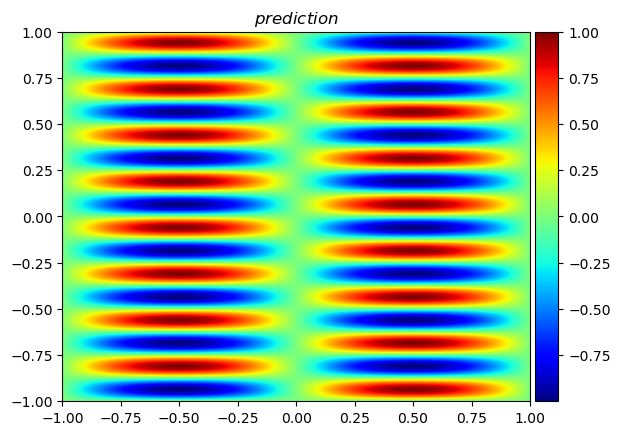

In [12]:
    fig = plt.figure()  #定义新的三维坐标轴
    ax = plt.axes(projection='3d')
    ax.axis('off')
    gs0 = gridspec.GridSpec(1, 2)
    ax = plt.subplot(gs0[:, :])
    h = ax.imshow(U_pred, interpolation='hermite', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    ax.set_title('$prediction$')
    #左边的色差图
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    #plt.savefig('Waterasdes.jpg', dpi=500, bbox_inches='tight') # 解决图片不清晰，不完整的问题
    #plt.savefig('0.12 mmpinn error.pdf', bbox_inches='tight') 
    plt.show() 

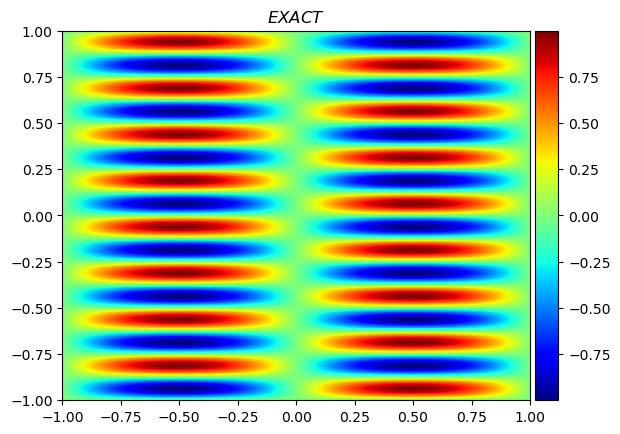

In [13]:
    fig = plt.figure()  #定义新的三维坐标轴
    ax = plt.axes(projection='3d')
    ax.axis('off')
    gs0 = gridspec.GridSpec(1, 2)
    ax = plt.subplot(gs0[:, :])
    h = ax.imshow(res.T, interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    ax.set_title('$EXACT$')
    #左边的色差图
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    #plt.savefig('Waterasdes.jpg', dpi=500, bbox_inches='tight') # 解决图片不清晰，不完整的问题
    #plt.savefig('0.12 mmpinn error.pdf', bbox_inches='tight') 
    plt.show() 